# **Importing Important Libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib 
import os 
import PIL
from PIL import Image

# **Loading and Preprocessing Data**

In [2]:
data_dir = pathlib.Path("Custom-Dataset-4")
print(len(list(data_dir.glob("*/*"))))


24886


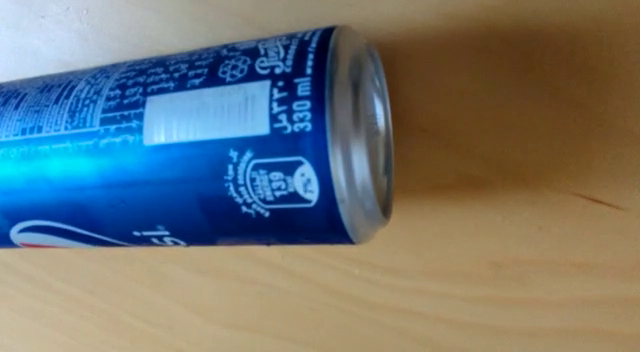

In [3]:
trash = list(data_dir.glob('Can/*'))
PIL.Image.open(str(trash[0]))

In [4]:
batch_size = 32
image_height = 224
image_width = 224

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 24886 files belonging to 4 classes.
Using 24638 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.01,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 24886 files belonging to 4 classes.
Using 248 files for validation.


In [40]:
# Don't run this cell if you are testing on a new dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [41]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 4


In [7]:
#Classes as inferred
class_names = train_ds.class_names
print(class_names)

['Can', 'General', 'Paper', 'Plastic']


In [8]:
# Evaluate the best model on the test data
test_ds = keras.preprocessing.image_dataset_from_directory(
    'Dataset-testing (from internet)',
    image_size=(224, 224),
    batch_size=32)

Found 699 files belonging to 3 classes.


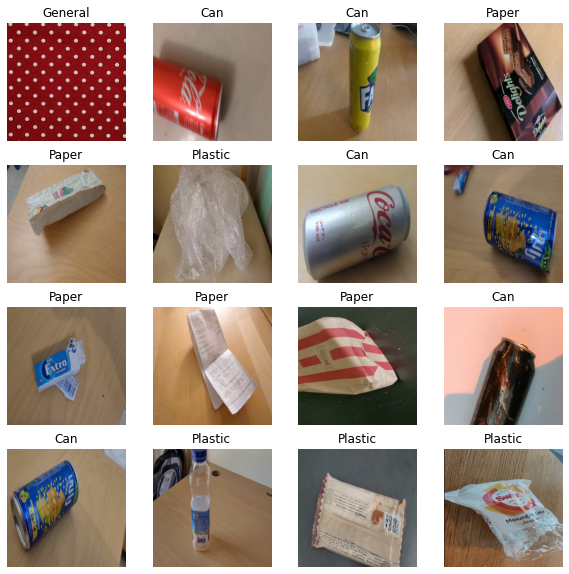

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


# **Configure Dataset Performance**

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
#test_ds= test_ds.prefetch(buffer_size=AUTOTUNE)

# **Data Augmentation**

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

#Load The Pre-trained Model - **VGG16**

In [11]:
#importing VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [12]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

#Don't train existing weights
base_model.trainable = False 

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# **Fine-tuning**

In [14]:
# Skip executing this cell if you don't want to carry out fine-tuning
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  19


# Build Custom Model with New Classifier **Head**

In [51]:
flat = layers.Flatten()
#globalMax = layers.GlobalMaxPooling2D()
d1 = layers.Dense(512,activation='relu')
d2 = layers.Dense(256,activation='relu')
drop = layers.Dropout(0.2) 
prediction_layer = layers.Dense(4,activation='softmax')

In [ ]:
pip install keras-tuner --upgrade

# **Automatic Model Tuner**

In [18]:
#from kerastuner.tuners import RandomSearch
import keras_tuner  as kt
from keras_tuner import RandomSearch # not used

# Define the hyperparameter search space
hp = {
    'dense_units': [128, 256, 512],
    'learning_rate': [1e-3, 1e-4, 1e-5],
    'dropout_rate': [0.3, 0.4, 0.5]
}

# Define the model architecture
def build_model(hp):
    flatten_layer = layers.Flatten()(base_model.output)
    dense_layer1 = layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(flatten_layer)
    dense_layer2 = layers.Dense(units=hp.Int('units', min_value=32, max_value=256, step=32), activation='relu')(dense_layer1)
    dropout_layer1 = layers.Dropout(rate=hp.Float('dropout',min_value=0.0, max_value=0.5, step=0.1, default=0.5))(dense_layer2)
    dense_layer3 = layers.Dense(units=4, activation='softmax')(dropout_layer1)

    model = keras.models.Model(inputs=base_model.input, outputs=dense_layer3)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model



In [ ]:
# Define tuner with search space and search algorithm
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='VGG16_tuner_hyperband',
    project_name='VGG16_hyperband1')

# Search for the best hyperparameters
tuner.search(train_ds,
             validation_data=test_ds,
             epochs=15)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [19]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='VGG16_tuner_random',
    project_name='VGG16_rand1')

tuner.search(train_ds,validation_data=test_ds,epochs=15)

# Retrieve the best model
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

Trial 1 Complete [19h 16m 10s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 19h 16m 10s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
512               |320               |units
0.2               |0.1               |dropout
0.01              |0.01              |learning_rate

Epoch 1/15
770/770 [==============================] - 1558s 2s/step - loss: 1.2660 - accuracy: 0.3470 - val_loss: 1.7339 - val_accuracy: 0.0000e+00
Epoch 2/15
770/770 [==============================] - 1557s 2s/step - loss: 1.2600 - accuracy: 0.3463 - val_loss: 1.7307 - val_accuracy: 0.0000e+00
Epoch 3/15
770/770 [==============================] - 1558s 2s/step - loss: 1.2600 - accuracy: 0.3468 - val_loss: 1.7330 - val_accuracy: 0.0000e+00
Epoch 4/15
770/770 [==============================] - 1550s 2s/step - loss: 1.2599 - accuracy: 0.3464 - val_loss: 1.7372 - val_accuracy: 0.0000e+00
Epoch 5/15
770/770 [==============================] - 1555s 2s/step - los

In [55]:
# Evaluate the best model on the test data
test_ds = keras.preprocessing.image_dataset_from_directory(
    'Dataset-testing (from internet)',
    image_size=(224, 224),
    batch_size=32)
#loss, accuracy = best_model.evaluate(test_ds)



#print(f'Test accuracy: {accuracy}')

Found 699 files belonging to 3 classes.


In [56]:
inputs = tf.keras.Input(shape=(image_height, image_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
#x = globalMax(x)
x = flat(x)
x = d1(x)
x = d2(x)
x = drop(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [57]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                           

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam('learning_rate',0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=10,verbose=1)

Epoch 1/10


525/525 [==============================] - 886s 2s/step - loss: 1.1081 - accuracy: 0.8269 - val_loss: 0.1719 - val_accuracy: 0.9414
Epoch 2/10
525/525 [==============================] - 120s 226ms/step - loss: 0.2296 - accuracy: 0.9201 - val_loss: 0.1259 - val_accuracy: 0.9555
Epoch 3/10
525/525 [==============================] - 120s 225ms/step - loss: 0.1613 - accuracy: 0.9464 - val_loss: 0.0906 - val_accuracy: 0.9700
Epoch 4/10
525/525 [==============================] - 120s 225ms/step - loss: 0.1305 - accuracy: 0.9548 - val_loss: 0.0587 - val_accuracy: 0.9798
Epoch 5/10
525/525 [==============================] - 120s 226ms/step - loss: 0.1026 - accuracy: 0.9645 - val_loss: 0.1033 - val_accuracy: 0.9650
Epoch 6/10
525/525 [==============================] - 121s 227ms/step - loss: 0.0913 - accuracy: 0.9686 - val_loss: 0.0672 - val_accuracy: 0.9769
Epoch 7/10
525/525 [==============================] - 120s 226ms/step - loss: 0.0914 - accuracy: 0.9692 - val_loss: 0.0670 - val_accuracy:

In [ ]:
#code for saving model 
model.save("/content/drive/My Drive/Models/VGG16-STBv1.3_3")

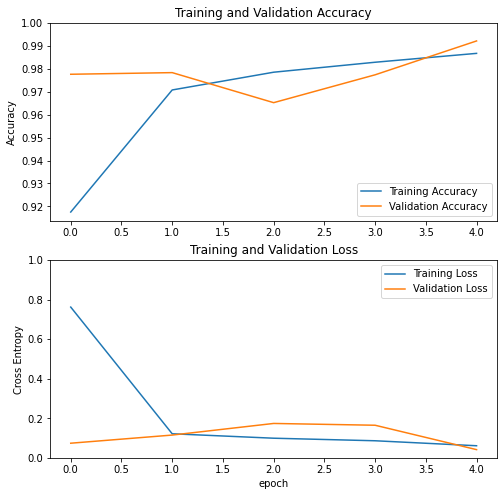

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Confusion Matrix**

In [ ]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

# **Evaluation and Prediction**

In [ ]:
# No need to do this if u just trained the model from above
# load trained model
l_model = tf.keras.models.load_model("/content/drive/My Drive/Models/VGG16-STBv1.2")
l_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [ ]:
# Evaluating on a new dataset from the internet
# paper and plastic from  https://www.kaggle.com/datasets/arthurcen/waste-images-from-sushi-restaurant
# can from https://universe.roboflow.com/dataset-t7hz7/cans-fdboa/dataset/1
test_dir = pathlib.Path("/content/drive/My Drive/Dataset-testing (from internet)")

batch_size = 32
image_height = 224
image_width = 224

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)


Found 699 files belonging to 3 classes.


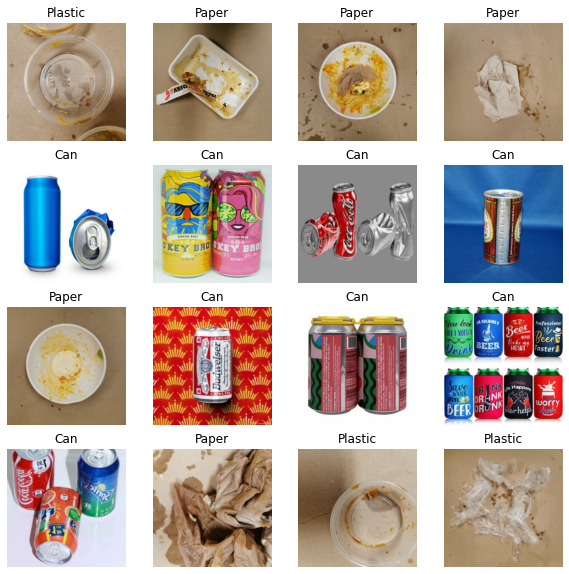

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(test_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

22/22 [==============================] - 26s 640ms/step - loss: 2.3702 - accuracy: 0.5680
Test accuracy : 0.5679542422294617


In [ ]:
# Retrieve a batch of images from the test set
# Not complete
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

score = tf.nn.softmax(predictions[0])

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


## Saving Model 

In [ ]:
#code for saving model 
model.save("/content/drive/My Drive/Models/VGG16-STBv1.3_2")

# **Loading The Model**

In [ ]:
model = tf.keras.models.load_model("/content/drive/My Drive/Models/VGG16-STBv1.0")

# Check its architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                             

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                             

# **Converting The Model to Lite**

In [1]:
import tensorflow as tf
# Convert the model.
model = tf.keras.models.load_model("Models/ResNet50-STBv1.0_17")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('Models/ResNet50-STBv1.0_17.Lite', 'wb') as f:
  f.write(tflite_model)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


INFO:tensorflow:Assets written to: /tmp/tmpakejs8rq/assets


INFO:tensorflow:Assets written to: /tmp/tmpakejs8rq/assets


In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  #plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
%pwd

'/content'

In [ ]:
l_model = keras.models.load_model('/content/drive/MyDrive/Models/model3')

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(l_model)
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/Models/model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
l_model = keras.models.load_model('/content/drive/MyDrive/Models/VGG16-STBv1.2')

In [ ]:
l_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

# **Fine-Tuning**

In [ ]:
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint

# Unfreeze all weights
for layer in model.layers:
    layer.trainable = True
    
# Recompile with Adam optimizer with smaller initial learning rate
adam_fine = Adam(lr=0.00002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # 50x smaller than standard
checkpoint = ModelCheckpoint('VGG19_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)